In [1]:
# !pip install interpret
# !pip install --user xgboost
# !pip install pytorch-tabnet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
dataset_folder = 'dataset/explain_te-master/selected/'

file = 'diaretino.csv'
class_names = [0, 1]
_class = 'dr'

In [4]:
df = pd.read_csv(dataset_folder + file)
df.replace(('yes', 'no'), (1, 0), inplace=True)
df.head()

qa  ps  ma0.5  ma0.6  ma0.7  ma0.8  ma0.9  ma1.0      ex0.5      ex0.6  \
0   1   1     22     22     22     19     18     14  49.895756  17.775994   
1   1   1     24     24     22     18     16     13  57.709936  23.799994   
2   1   1     62     60     59     54     47     33  55.831441  27.993933   
3   1   1     55     53     53     50     43     31  40.467228  18.445954   
4   1   1     44     44     44     41     39     27  18.026254   8.570709   

       ex0.7     ex0.8     ex0.9     ex1.0      exm1      exm2    eucmac  \
0   5.270920  0.771761  0.018632  0.006864  0.003923  0.003923  0.486903   
1   3.325423  0.234185  0.003903  0.003903  0.003903  0.003903  0.520908   
2  12.687485  4.852282  1.393889  0.373252  0.041817  0.007744  0.530904   
3   9.118901  3.079428  0.840261  0.272434  0.007653  0.001531  0.483284   
4   0.410381  0.000000  0.000000  0.000000  0.000000  0.000000  0.475935   

     diaopt  amfm  dr  
0  0.100025     1   0  
1  0.144414     0   0  
2  0.128548     0   1  
3  0.114790     0   0  
4  0.123572     0   1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qa      1151 non-null   int64  
 1   ps      1151 non-null   int64  
 2   ma0.5   1151 non-null   int64  
 3   ma0.6   1151 non-null   int64  
 4   ma0.7   1151 non-null   int64  
 5   ma0.8   1151 non-null   int64  
 6   ma0.9   1151 non-null   int64  
 7   ma1.0   1151 non-null   int64  
 8   ex0.5   1151 non-null   float64
 9   ex0.6   1151 non-null   float64
 10  ex0.7   1151 non-null   float64
 11  ex0.8   1151 non-null   float64
 12  ex0.9   1151 non-null   float64
 13  ex1.0   1151 non-null   float64
 14  exm1    1151 non-null   float64
 15  exm2    1151 non-null   float64
 16  eucmac  1151 non-null   float64
 17  diaopt  1151 non-null   float64
 18  amfm    1151 non-null   int64  
 19  dr      1151 non-null   int64  
dtypes: float64(10), int64(10)
memory usage: 180.0 KB


In [6]:
X, y = df.drop(columns=[_class]), df[_class]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [8]:
x_test.shape

(346, 19)

# EDA

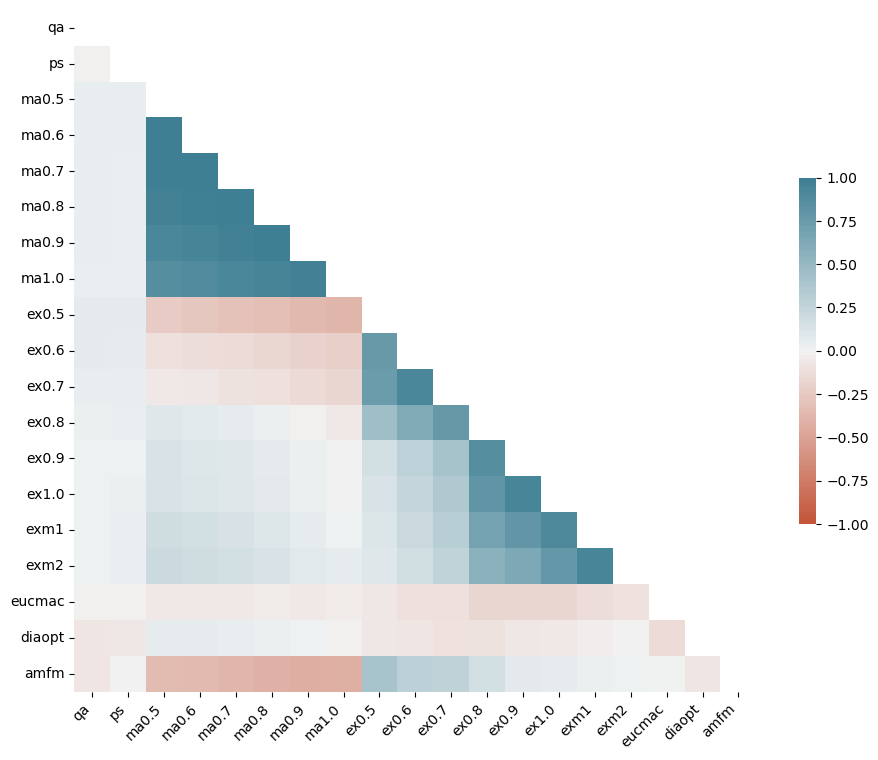

In [9]:
data = x_train
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(
    corr, mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,  cbar_kws={"shrink": .5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, 834 to 1126
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qa      805 non-null    int64  
 1   ps      805 non-null    int64  
 2   ma0.5   805 non-null    int64  
 3   ma0.6   805 non-null    int64  
 4   ma0.7   805 non-null    int64  
 5   ma0.8   805 non-null    int64  
 6   ma0.9   805 non-null    int64  
 7   ma1.0   805 non-null    int64  
 8   ex0.5   805 non-null    float64
 9   ex0.6   805 non-null    float64
 10  ex0.7   805 non-null    float64
 11  ex0.8   805 non-null    float64
 12  ex0.9   805 non-null    float64
 13  ex1.0   805 non-null    float64
 14  exm1    805 non-null    float64
 15  exm2    805 non-null    float64
 16  eucmac  805 non-null    float64
 17  diaopt  805 non-null    float64
 18  amfm    805 non-null    int64  
dtypes: float64(10), int64(9)
memory usage: 125.8 KB


# ML Model

In [11]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [13]:
random_state=42

In [14]:
x_train

qa  ps  ma0.5  ma0.6  ma0.7  ma0.8  ma0.9  ma1.0       ex0.5      ex0.6  \
834    1   1     85     73     70     62     59     37   43.873596  17.321847   
29     1   1    103     89     83     71     60     38   11.025085   3.762343   
745    1   1     12     11     11     11     10      8   73.975723  39.190608   
165    1   1     19     19     19     18     15      9   13.115054   5.845388   
248    1   1     58     57     55     50     43     34   31.499303  16.223873   
...   ..  ..    ...    ...    ...    ...    ...    ...         ...        ...   
1044   1   1     18     18     18     17     13     10   22.320425  10.157700   
1095   1   1     34     34     34     34     33     24  136.285159  25.909910   
1130   1   1     37     36     33     24     18     10   37.686807   4.978201   
860    1   1     11      7      6      6      6      5   31.073428  14.277795   
1126   1   1      4      4      4      4      4      3  118.036826  21.578380   

          ex0.7     ex0.8     ex0.9     ex1.0      exm1      exm2    eucmac  \
834    4.708070  1.229496  0.119951  0.015783  0.014205  0.012626  0.548025   
29     0.015592  0.010914  0.003118  0.003118  0.001559  0.001559  0.488566   
745    6.678279  0.779589  0.121811  0.014211  0.000000  0.000000  0.475377   
165    0.154330  0.050435  0.000000  0.000000  0.000000  0.000000  0.484477   
248    7.405699  0.924929  0.163038  0.083087  0.026650  0.010974  0.519667   
...         ...       ...       ...       ...       ...       ...       ...   
1044   0.657133  0.044193  0.007686  0.003843  0.000000  0.000000  0.570065   
1095  15.509432  5.114110  0.307383  0.048480  0.000000  0.000000  0.523087   
1130   1.180336  0.184896  0.024986  0.007996  0.000000  0.000000  0.535271   
860    1.746907  0.010051  0.000000  0.000000  0.000000  0.000000  0.531741   
1126   7.407548  0.725415  0.003959  0.003959  0.003959  0.003959  0.508743   

        diaopt  amfm  
834   0.107324     0  
29    0.134091     0  
745   0.117750     0  
165   0.109948     0  
248   0.125414     0  
...        ...   ...  
1044  0.090308     1  
1095  0.129967     1  
1130  0.093947     0  
860   0.133682     0  
1126  0.105893     1  

[805 rows x 19 columns]

In [15]:
def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        f1, acc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred)
        data.append([name, f1, acc])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.'])
    df = df.sort_values(by=['F1'])
    return df

In [16]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [15, 25, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 15, 20],
    'min_samples_leaf': [1, 4, 8],
    'bootstrap': [False]
}

# Initialize the GridSearchCV with training data only
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score from training data
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Training Score: {grid_search.best_score_}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100}
Best Training Score: 0.693167701863354


In [17]:
from sklearn.metrics import accuracy_score
# Evaluate the best model on the test data
# best_rf = grid_search.best_estimator_
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=random_state)
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_test)
# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy}")

Test Set Accuracy: 0.6763005780346821


In [18]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
_xgb = xgb.XGBClassifier(random_state=random_state)
ebm = ExplainableBoostingClassifier(random_state=random_state)
tbn = TabNetClassifier(verbose=0, seed=random_state)

clfs = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
# clfs = [(rf, 'rf', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
dataset = x_train, y_train, x_test, y_test
classify_report(clfs, dataset)

Name        F1      Acc.
0   rf  0.681948  0.679191
4  tbn  0.701887  0.543353
3  ebm  0.706849  0.690751
2  xgb  0.707521  0.696532
1  gbc  0.727273  0.713873

# XAI

In [19]:
# selected_model = _xgb
# For fairness of comparisions we used RF
selected_model = rf

In [20]:
import time, datetime
from joblib import Parallel, delayed
import itertools

n_jobs = 8

In [21]:
class_names = ['NO','YES']
feature_names = x_train.columns.to_list()
# local = lime, shap, anchor, tabnet, ebm
# global = pfi, tabnet, ebm, shap
# methods = pfi, tabnet, ebm, shap, lime, anchor
# remaining = pdp, eli5, ice, adawhip, break down

## Local

### LIME

In [22]:
import lime
from lime import lime_tabular

In [23]:
exp_lime=lime_tabular.LimeTabularExplainer(np.array(x_train),feature_names=x_train.columns,class_names=['NO','YES'],mode='classification')

In [24]:

def lime_explain_instance_step(i, lim):
    warnings.filterwarnings("ignore")
    out = []
    for k in range(i, lim):
        e = exp_lime.explain_instance(x_test.values[k], selected_model.predict_proba)
        out.append(e)
    return out

# lime_explanations_list = [exp_lime.explain_instance(x_test.values[i], selected_model.predict_proba) for i in range(len(x_test))]  # sequential and slower
total = len(x_test)
out = Parallel(n_jobs=n_jobs)(delayed(lime_explain_instance_step)(i, min(total, i+int(total/n_jobs))) for i in range(0, total, int(total/n_jobs)))
lime_explanations_list = list(itertools.chain(*out))


In [25]:
display(x_test.iloc[9:11])
display(y_test.iloc[9:11])

qa  ps  ma0.5  ma0.6  ma0.7  ma0.8  ma0.9  ma1.0       ex0.5      ex0.6  \
328   1   1     44     44     44     44     42     29   25.281979  12.051879   
692   1   1     47     44     41     39     34     24  137.877736  24.437388   

         ex0.7    ex0.8     ex0.9     ex1.0      exm1  exm2    eucmac  \
328   1.637867  0.18539  0.000000  0.000000  0.000000   0.0  0.500516   
692  10.652664  2.66342  0.257193  0.130121  0.001017   0.0  0.487769   

       diaopt  amfm  
328  0.144022     0  
692  0.112840     1

328    0
692    1
Name: dr, dtype: int64

In [26]:
id_to_explain = 9
lime_explanations_list[id_to_explain].show_in_notebook(show_table=True)

In [27]:
id_to_explain = 10
lime_explanations_list[id_to_explain].show_in_notebook(show_table=True)

### SHAP

In [28]:
import shap
shap.plots.initjs()

In [29]:
exp_shap = shap.TreeExplainer(selected_model)
shap_values = exp_shap.shap_values(x_test)

In [30]:
# shap.force_plot(exp_shap.expected_value, shap_values[id_to_explain], x_test.iloc[id_to_explain])
shap.force_plot(exp_shap.expected_value[0], shap_values[id_to_explain][:,0], x_test.iloc[id_to_explain])

In [31]:
exp_shap_values = exp_shap(x_test)

In [32]:
# print(exp_shap.expected_value + sum(shap_values[3]))
print(exp_shap.expected_value[0] + sum(shap_values[4][:, 0]))
print(selected_model.predict_proba(x_test)[4, 0])

0.5500000000000002
0.55


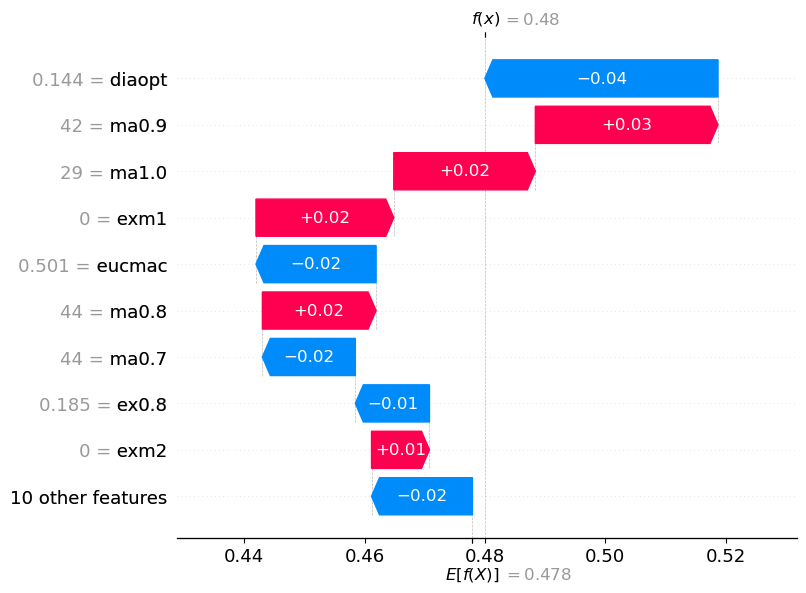

In [33]:
id_to_explain = 9
output_to_explain = 0

# shap.plots.waterfall(exp_shap_values[id_to_explain], max_display=10)
shap.plots.waterfall(exp_shap_values[id_to_explain,:,output_to_explain], max_display=10)

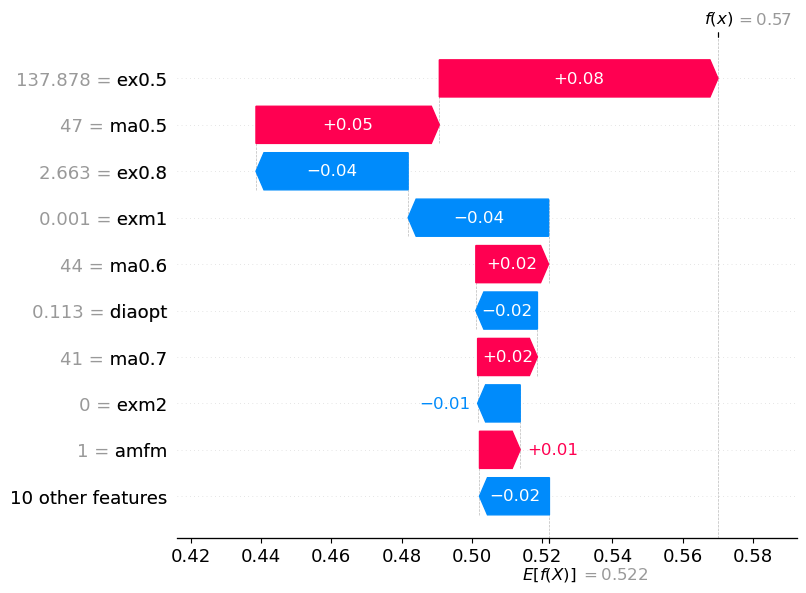

In [34]:
id_to_explain = 10
output_to_explain = 1
# shap.plots.waterfall(exp_shap_values[id_to_explain], max_display=10)
shap.plots.waterfall(exp_shap_values[id_to_explain,:,output_to_explain], max_display=10)

#### Fidelity

In [35]:
selected_model_predict_proba_array = selected_model.predict_proba(x_test)
selected_model_predict_array = selected_model.predict(x_test)

In [36]:
id_to_test = 10
print('LIME', selected_model_predict_proba_array[id_to_test, 1], lime_explanations_list[id_to_test].local_pred[0])
print(int(lime_explanations_list[id_to_test].local_pred[0]>0.5))
print('SHAP', selected_model_predict_proba_array[id_to_test, 1], exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1]))
print(int(exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1])>0.5))
del id_to_test

LIME 0.57 0.6627411390836013
1
SHAP 0.57 0.5699999999999997
1


In [45]:
lime_fidelity = np.mean([1-np.abs(selected_model_predict_proba_array[i, 1] - (lime_explanations_list[i].local_pred[0])) for i in range(len(x_test))])
print(f'LIME Fidelity: {lime_fidelity:.4f}')

# For SHAP, fidelity is usually high as it's designed to be an accurate representation of the model
shap_fidelity = np.mean([1-np.abs(selected_model_predict_proba_array[i, 1] - (exp_shap.expected_value[1] + np.sum(shap_values[i][:, 1]))) for i in range(len(x_test))])
print(f'SHAP Fidelity: {shap_fidelity:.4f}')

LIME Fidelity: 0.8334
SHAP Fidelity: 1.0000


In [38]:
# accuracy_score(selected_model.predict(X_test), np.argmax(shap_values, axis=1))
from sklearn.metrics import accuracy_score

lime_predict_array = np.array([int(lime_explanations_list[i].local_pred[0]>0.5) for i in range(len(x_test))])
shap_predict_array = np.array([int(exp_shap.expected_value[1] + np.sum(shap_values[i][:, 1])>0.5) for i in range(len(x_test))])

print(f'LIME Fidelity (Predict): {accuracy_score(selected_model_predict_array, lime_predict_array):.4f}')
print(f'SHAP Fidelity (Predict): {accuracy_score(selected_model_predict_array, shap_predict_array):.4f}')

LIME Fidelity (Predict): 0.5520
SHAP Fidelity (Predict): 0.9942


In [43]:
differing_indices = np.where(selected_model_predict_array != shap_predict_array)[0]
differing_indices

array([ 72, 149])

In [44]:
for id_to_test in differing_indices:
    print('LIME', selected_model_predict_proba_array[id_to_test, 1], lime_explanations_list[id_to_test].local_pred[0])
    print(int(lime_explanations_list[id_to_test].local_pred[0]>0.5))
    print('SHAP', selected_model_predict_proba_array[id_to_test, 1], exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1]))
    print(int(exp_shap.expected_value[1] + np.sum(shap_values[id_to_test][:, 1])>0.5))
del id_to_test

LIME 0.5 0.5412231196303877
1
SHAP 0.5 0.5000000000000001
1
LIME 0.5 0.5116549881045794
1
SHAP 0.5 0.5000000000000007
1


In [36]:
# lime_fidelity = np.mean([np.abs(selected_model_predict_proba_array[i, 0] - (lime_explanations_list[i].local_pred[0])) for i in range(len(x_test))])
# print(f'LIME Fidelity: {lime_fidelity:.2f}')

# # For SHAP, fidelity is usually high as it's designed to be an accurate representation of the model
# shap_fidelity = np.mean([np.abs(selected_model_predict_proba_array[i, 1] - (exp_shap.expected_value[0] + np.sum(shap_values[i][:, 0]))) for i in range(len(x_test))])
# print(f'SHAP Fidelity: {shap_fidelity:.2f}')

LIME Fidelity: 0.25
SHAP Fidelity: 0.38


In [37]:
# # accuracy_score(selected_model.predict(X_test), np.argmax(shap_values, axis=1))
# from sklearn.metrics import accuracy_score

# lime_predict_array = np.array([1 if lime_explanations_list[i].local_pred[0]>0.5 else 0 for i in range(len(x_test))])
# shap_predict_array = np.array([0 if exp_shap.expected_value[0] + np.sum(shap_values[i][:, 0])>exp_shap.expected_value[0] + np.sum(shap_values[i][:, 1]) else 1 for i in range(len(x_test))])

# print(f'LIME Fidelity (Predict): {accuracy_score(selected_model_predict_array, lime_predict_array):.4f}')
# print(f'SHAP Fidelity (Predict): {accuracy_score(selected_model_predict_array, shap_predict_array):.4f}')

LIME Fidelity (Predict): 0.5491
SHAP Fidelity (Predict): 0.9682


### EBM

In [38]:
ebm_local = ebm.explain_local(x_test, y_test, name='EBM')

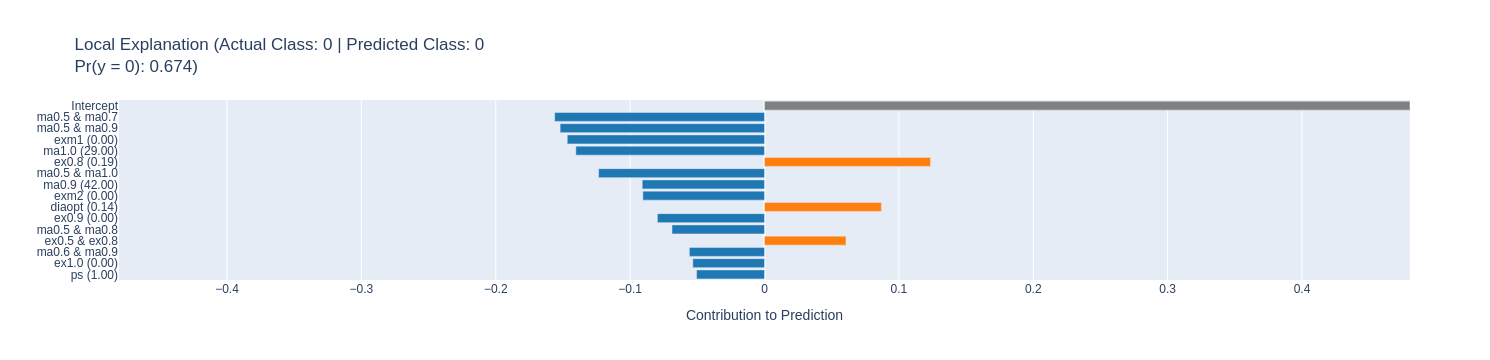

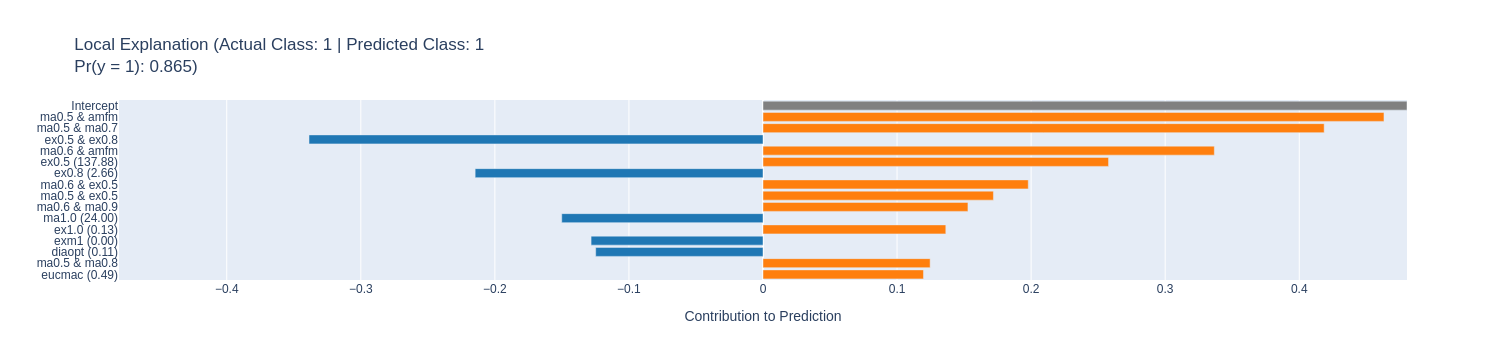

In [39]:
# show(ebm.explain_local(x_test[554:555+1], y_test[554:555+1]), 0)
preserve(ebm_local, 9)
preserve(ebm_local, 10)

### TABNET

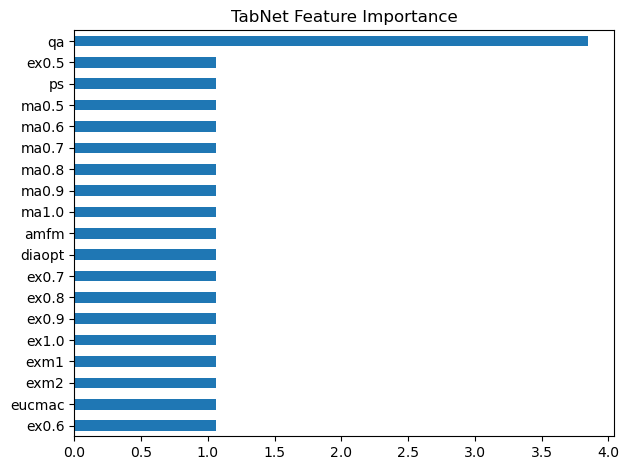

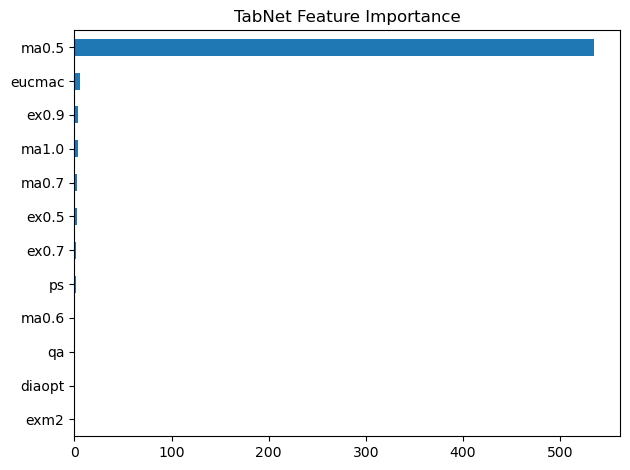

In [40]:
explain_tabnet_matrix, tabnet_masks = tbn.explain(x_test.values)

def get_tbn_local_graph(idx, feature_names):
    m = explain_tabnet_matrix[idx]>0
    ax = pd.Series(explain_tabnet_matrix[idx][m], index=np.array(feature_names)[m]).sort_values(ascending=True).plot.barh()
    ax.set_title("TabNet Feature Importance")
    ax.figure.tight_layout()
    plt.show()

get_tbn_local_graph(9, feature_names)
get_tbn_local_graph(10, feature_names)

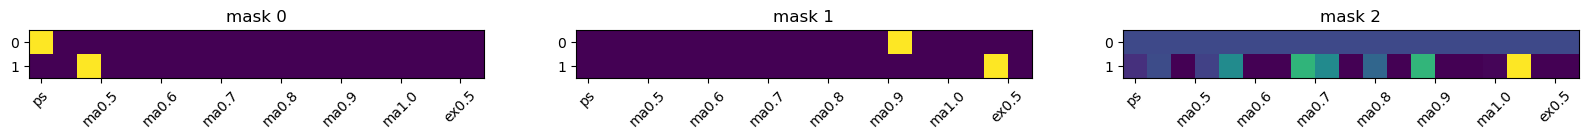

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))


for i in range(3):
    axs[i].imshow(tabnet_masks[i][9:11])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(labels = feature_names, rotation=45)

#### Simplicity

In [42]:
# https://link.springer.com/chapter/10.1007/978-3-031-20319-0_30
# Simplicity is the ability to choose only the necessary and sufficient features for explaining the prediction.

# Calculate simplicity
def calculate_simplicity(_values, threshold=0.05):
    simplicity_scores = []
    for instance_value in _values:
        abs_values = np.abs(instance_value)
        num_important_features = np.sum( abs_values > (max(abs_values) *threshold))
        simplicity_scores.append(num_important_features)
    return np.mean(simplicity_scores)


def get_simplicity_dict(name, values, threshold_list=[0.1, 0.05, 0.01]):
    d = {'Method': name}
    for threshold in threshold_list:
        d[threshold] = calculate_simplicity(values, threshold)
    return d

lime_feature_values = [list(zip(*lime_explanations_list[i].as_list()))[1] for i in range(len(x_test))]
ebm_local_scroes = [ebm_local.data(i)['scores'] for i in range(len(x_test))]

list_of_scores_dict = [get_simplicity_dict(name, values) for name, values in 
                       [('LIME', lime_feature_values), ('SHAP', shap_values[:,:,0]), ('EBM', ebm_local_scroes),
                        ('TABNET', explain_tabnet_matrix)]]

_df_simplicity = pd.DataFrame(list_of_scores_dict)
_df_simplicity.set_index('Method', inplace=True)
_df_simplicity


0.1       0.05       0.01
Method                                 
LIME     9.872832  10.000000  10.000000
SHAP    11.439306  14.234104  17.101156
EBM     20.112717  27.156069  35.627168
TABNET   6.098266   7.335260   9.884393

In [43]:
# Common Top Feature Agreement

def retain_top_features(features, n=5):
    arr = np.abs(features)
    # Get the indices of the top n maximum values
    indices = np.argpartition(arr, -n)[-n:]

    # Create a mask
    mask = np.zeros_like(arr, dtype=bool)
    mask[indices] = True
    return np.where(mask, features, 0)

# lime_explanations_list[554].show_in_notebook(show_table=True)
# shap.plots.waterfall(exp_shap_values[554,:,output_to_explain], max_display=3)
def get_lime_feature_importance(lime_exp):
    feature_importance = {}
    for feature, sc in lime_exp.as_list():
        # print(feature)
        # Split feature by '<', '>', or '=' and take the first part as the feature name
        if feature.find('< ')>-1:
            feature = feature.split(' < ')[1]
        feature = feature.split(' > ')[0].strip()
        feature = feature.split(' <= ')[0].strip()
        for f in ['>', '<', '=']:
            if feature.find(f)>-1:
                print('error', feature)
        feature_importance[feature] = sc
    # print(feature_importance)
    # print([feature_importance.get(feature, 0) for feature in feature_names])
    return np.array([feature_importance.get(feature, 0) for feature in feature_names])

# lime_weights = dict(lime_explanations_list[0].as_list())
# lime_weights.get('Number_of_ANC_Visits', 0)
# pd.DataFrame([(shap_values[i][:, 0][1], get_lime_feature_importance(lime_explanations_list[i])[1]) for i in range(20)]).corr()
print(feature_names)

# np.nonzero(retain_top_features(shap_values[554][:, 1], 2))[0], np.nonzero(retain_top_features(get_lime_feature_importance(lime_explanations_list[554]), 2))[0]

['qa', 'ps', 'ma0.5', 'ma0.6', 'ma0.7', 'ma0.8', 'ma0.9', 'ma1.0', 'ex0.5', 'ex0.6', 'ex0.7', 'ex0.8', 'ex0.9', 'ex1.0', 'exm1', 'exm2', 'eucmac', 'diaopt', 'amfm']


In [44]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from scipy.stats import shapiro

shap_val = lambda x, top_n=2: retain_top_features(shap_values[x][:, 1], top_n)
lime_val = lambda x, top_n=2: retain_top_features(get_lime_feature_importance(lime_explanations_list[x]), top_n)

def check_significant_differnce(dist1, dist2, top_n=2):
    data_process_1 = dist1
    data_process_2 = dist2
    
    # Shapiro-Wilk test
    # Shapiro-Wilk Test: If the p-value is less than 0.05, the null hypothesis that the data is normally distributed is rejected.
    for data in [data_process_1, data_process_2]:
        stat, p_value = shapiro(data)
        if not p_value<0.05:
            print('Alert: Normally distributed')
            print(f'Shapiro-Wilk test: Statistics={stat}, p-value={p_value}')
    
    
    # A suitable test in this context would be the paired t-test if the data is normally distributed or the Wilcoxon signed-rank test if the data is not normally distributed.
    # Paired t-test
    # t_statistic, p_value_ttest = ttest_rel(data_process_1, data_process_2)
    # print(f"Paired t-test: t-statistic = {t_statistic}, p-value = {p_value_ttest}")
    
    # Wilcoxon signed-rank test
    w_statistic, p_value_wilcoxon = wilcoxon(data_process_1, data_process_2)
    # print(f"Wilcoxon signed-rank test: w-statistic = {w_statistic}, p-value = {p_value_wilcoxon}")
    if p_value_wilcoxon<0.05:
        print('Alert: significant difference')
    
    # If the p-value is less than the chosen significance level (e.g., 0.05), you reject the null hypothesis and conclude that there is a significant difference between the means of the two processes.
    return p_value_wilcoxon

lime_shap_diff_p = [ check_significant_differnce(lime_val(i, top_n=2), shap_val(i, top_n=2), ) for i in range(len(x_test))]

#### Consistency

In [45]:
# Consistency measures how similar the explanations produced by different XAI methods are when applied to the same input data

shap_val = lambda x, top_n=2: retain_top_features(shap_values[x][:, 1], top_n)
lime_val = lambda x, top_n=2: retain_top_features(get_lime_feature_importance(lime_explanations_list[x]), top_n)
tabnet_val = lambda x, top_n=2: retain_top_features(explain_tabnet_matrix[x], top_n)
from scipy.stats import spearmanr

def get_consistency(method1, method2):
    numerator = 0
    divider = 0
    avg_sp_corr_list = []
    for n in range(1, 6): #only top 5 features: 1 feature is counted 5 five times, 2 four times,.. 5th only one time.
        
        # Compute Spearman's rank correlation coefficient
        spearman_corr_array = np.array([spearmanr(method1(i, top_n=n), method2(i, top_n=n))[0] for i in range(len(x_test))])
        avg_spearman_corr = spearman_corr_array.mean()
        avg_sp_corr_list.append(avg_spearman_corr)
    
    return np.array(avg_sp_corr_list).mean()

print(f'LIME, SHAP Consistency: {get_consistency(lime_val, shap_val):.2f}')
print(f'LIME, TABNET Consistency: {get_consistency(lime_val, tabnet_val):.2f}')
print(f'TABNET, SHAP Consistency: {get_consistency(tabnet_val, shap_val):.2f}')

LIME, SHAP Consistency: 0.51
LIME, TABNET Consistency: -0.03
TABNET, SHAP Consistency: -0.08


#### Robustness

In [46]:
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

x_test_noisy = add_noise(x_test)
display(x_test_noisy)

lime_explanations_list_noisy = [exp_lime.explain_instance(x_test_noisy.values[i], selected_model.predict_proba) for i in range(len(x_test))]
shap_values_noisy = exp_shap.shap_values(x_test_noisy)
ebm_local_noisy = ebm.explain_local(x_test_noisy, y_test, name='EBM')
explain_tabnet_matrix_noisy, tabnet_masks_noisy = tbn.explain(x_test_noisy.values)

qa        ps      ma0.5      ma0.6      ma0.7      ma0.8  \
174   1.004799  0.001516  12.993189  12.993834  12.982888  11.993576   
752   0.995390  1.014204  56.991054  56.013553  53.994002  49.012087   
467   1.003774  1.007150  59.990488  59.009795  57.002229  54.995010   
240   0.997924  0.996669  47.989968  48.012210  47.993826  48.013822   
667   1.012314 -0.021663  26.998187  26.990177  27.005100  25.018980   
...        ...       ...        ...        ...        ...        ...   
931   1.001287  1.008931  16.994942  17.001837  17.016145  13.996073   
1054  0.997063  0.986222  16.998181  16.987846  15.997578  13.991933   
961   0.998612  0.992654  54.988156  54.010450  52.990288  53.016369   
617   0.996279  0.012036  62.008554  61.999570  60.999172  54.995355   
714   1.006608  1.004497  29.981925  29.992481  29.007443  26.994961   

          ma0.9      ma1.0       ex0.5       ex0.6      ex0.7      ex0.8  \
174   10.997758   5.977891   31.006568   14.269182   1.017967   0.051805   
752   46.986433  33.985133   61.396762   29.786264   6.212235   0.429581   
467   48.997411  33.006298   50.251617   35.382314  13.516995   4.268617   
240   41.009763  30.000187   34.022739   13.444588   6.039989   1.524006   
667   22.995704  19.006604   10.726143    4.544385   1.358745   0.089074   
...         ...        ...         ...         ...        ...        ...   
931   11.987773   9.006835   68.669982   23.985216   8.876031   1.380070   
1054   9.989667   9.989666  236.220844  107.779887  65.594507  14.572900   
961   51.989168  46.009735   42.829690   22.424199   4.283297   0.479518   
617   51.997169  45.011461   43.404033   28.467483  11.755690   2.081221   
714   25.003506  20.005345   22.734599    5.912638   1.181213   0.071572   

         ex0.9     ex1.0      exm1      exm2    eucmac    diaopt      amfm  
174  -0.011293 -0.003492 -0.011175 -0.000488  0.556932  0.129717 -0.003908  
752  -0.003707 -0.013299  0.001203  0.009216  0.550000  0.112861 -0.002466  
467   1.944348  0.364556  0.048627 -0.008356  0.532819  0.152263  0.001128  
240   0.330280  0.010042 -0.012562  0.014184  0.541671  0.086280  0.003992  
667   0.014479  0.006929  0.007366 -0.002218  0.506211  0.121235  1.003137  
...        ...       ...       ...       ...       ...       ...       ...  
931   0.129307  0.029254  0.032185 -0.008489  0.501956  0.113173  0.982510  
1054  0.077443 -0.009034 -0.017412  0.000999  0.500078  0.104448  0.987135  
961  -0.013989  0.002561  0.018798 -0.010719  0.526910  0.088778  0.001742  
617   0.174407 -0.018794 -0.002439  0.006733  0.477697  0.105901 -0.001688  
714  -0.000679  0.013458  0.014433  0.013078  0.531102  0.105469 -0.004985  

[346 rows x 19 columns]

In [47]:


# Function to calculate changes in explanations
def calculate_robustness(original, noisy):
    arr_org = np.array(original)
    arr_noisy = np.array(noisy)
    change_matrix = np.abs(arr_org - arr_noisy)
    divisor = max( [arr_org.max(), arr_noisy.max()] ) - min(  [arr_org.min(), arr_noisy.min()]  )  # max - min normalise
    return change_matrix.mean() / divisor  # divided in order to normalise between 0 to 1 (otherwise when the feature importance goes beyond 1 and under -1 such as in tabnet, ebm this won't normalise to 1)

def lime_robustness(original, noisy):
    means_list = []
    _max, _min = 0, 0
    for i in range(len(original)):
        d1, d2 = dict(original[i].as_list()), dict(noisy[i].as_list())
        # print(d1.keys())
        # print(d2.keys())
        v1, v2 = list(zip(*[[d1.get(f, 0), d2.get(f, 0)] for f in set(list(d1.keys())+list(d2.keys()))]))
        arr_org = np.array(v1)
        arr_noisy = np.array(v2)
        _max = max( [arr_org.max(), arr_noisy.max(), _max] )
        _min = min( [arr_org.min(), arr_noisy.min(), _min] )
        means_list.append(np.abs(arr_org - arr_noisy).mean())
    divisor = _max - _min
    return np.array(means_list).mean()/divisor # max - min normalise
        


print('Robustness')

print(f'LIME: {lime_robustness(lime_explanations_list, lime_explanations_list_noisy):.4f}')
print(f'SHAP: {calculate_robustness(shap_values, shap_values_noisy):.4f}')
_ebm_robustness = calculate_robustness([ebm_local.data(i)['scores'] for i in range(len(x_test))], [ebm_local_noisy.data(i)['scores'] for i in range(len(x_test))])
print(f'EBM: {_ebm_robustness:.4f}')
print(f'TABNET: {calculate_robustness(explain_tabnet_matrix, explain_tabnet_matrix_noisy):.4f}')


Robustness
LIME: 0.0444
SHAP: 0.0139
EBM: 0.0022
TABNET: 0.0012


## Global

### PMI

Elapsed time to compute the importances: 1.655 seconds


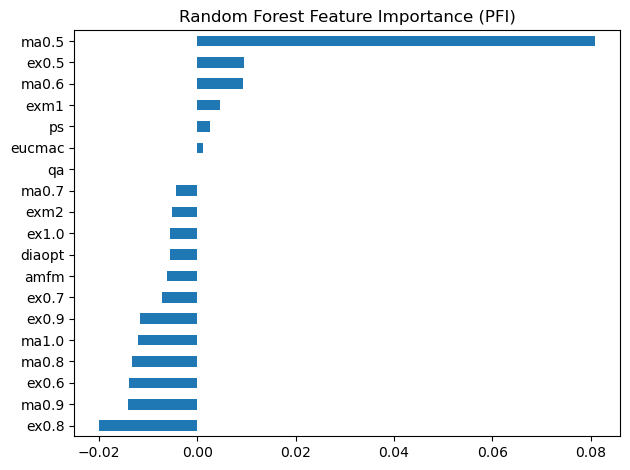

In [48]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    selected_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

selected_model_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=True)

ax = selected_model_importances.plot.barh()
ax.set_title("Random Forest Feature Importance (PFI)")
ax.figure.tight_layout()

### TABNET

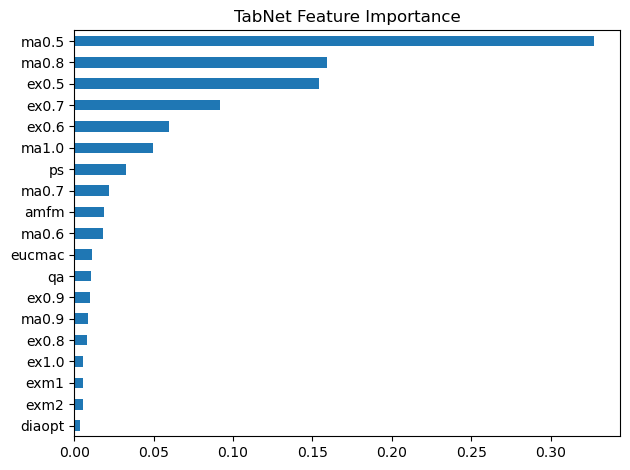

In [49]:
ax = pd.Series(tbn.feature_importances_, index=feature_names).sort_values(ascending=True).plot.barh()
ax.set_title("TabNet Feature Importance")
ax.figure.tight_layout()

### EBM

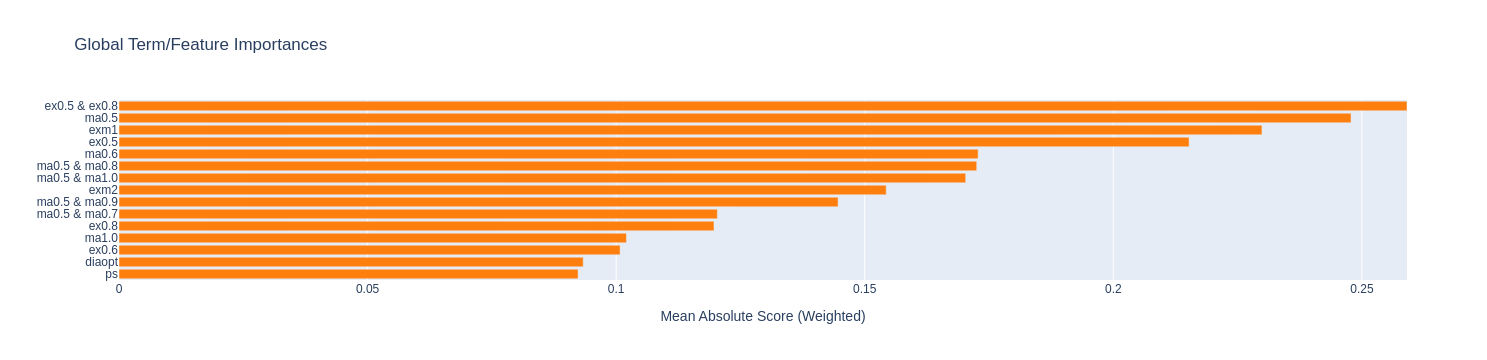

In [50]:
ebm_global = ebm.explain_global()
# show(ebm_global)

# Replace show with the preserve.

# ebm_global = ebm.explain_global(name='EBM')
# show(ebm_global)

# preserve(ebm_global, file_name='output/global-graph.html')
preserve(ebm_global)

### SHAP

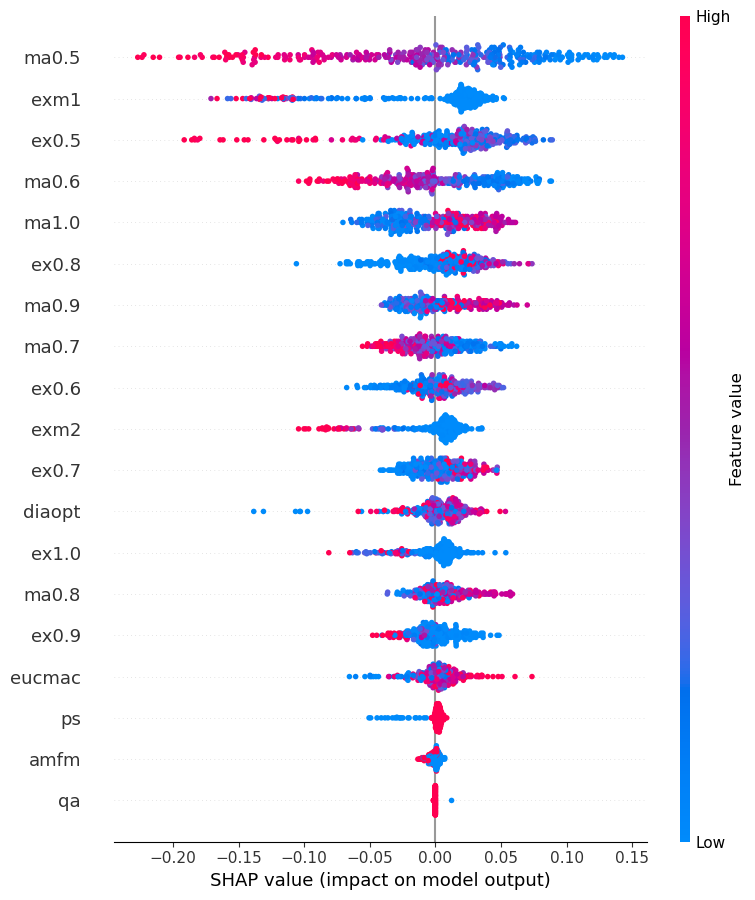

In [51]:
shap.summary_plot(shap_values[:,:,0], x_test)
# shap.summary_plot(shap_values[:,:,0], X_test)

In [52]:
# f.savefig("summary_plot_CS.png", bbox_inches='tight', dpi=600)